In [5]:
import pandas as pd
import numpy as np

from scipy.fft import fft, fftfreq, ifft, fft2, ifft2, ifftshift
from scipy.signal import blackman
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
from scipy.signal import butter
from scipy import signal
from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration
from scipy.ndimage import gaussian_filter as gf

from xrdc import featurization as feat
from xrdc import fourier
from xrdc.datasets import d3d


#pd.options.plotting.backend = "matplotlib"
pd.options.plotting.backend = "plotly"

Loading Data from: /Users/ollie/Documents/SLAC/xrd_clustering/notebooks/../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/
Data Loaded Succesfully
(177, 800)


In [2]:
from xrdc import source_separation as sep
from xrdc import featurization as feat
from xrdc.datasets import d3d

In [195]:
df = pd.read_csv("YijinXRD.dat", sep = '\t')
qq = df.iloc[:, 0]

patterns = df.iloc[:, 2:]
patterns = (patterns.values.T)[:, 1:]

for i in range(len(patterns)):
    patterns[i] = patterns[i] - i * 1000
    
background_extra, _, _, _ = sep.separate_signal(patterns, background_after_filter = False,
                                                    threshold = 50, smooth_q = 1.7, bg_fill_method = 'simple',
                                                    smooth_q_background = 6)

(0, 0)


In [244]:
# multiply normalized patterns by 1000 so that the peak-finding routine will play nice
patterns = m3d = 1000 * d3d.get_data().copy()[7, :, :]
#patterns = m3d_agglom# = m3d.reshape(15, 15, -1, 2).sum(axis = 3)

tmp = np.zeros_like(patterns)
tmp[:patterns.shape[0], :background_extra.shape[1]] = background_extra[:patterns.shape[0], :]
tmp = sep.CTinterpolation(tmp)

tmp *= (patterns.mean() / tmp.mean())

patterns = patterns + 2 * tmp

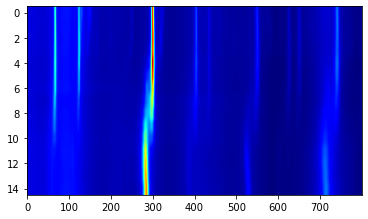

In [245]:
plt.imshow(patterns, cmap = 'jet', aspect = 30)

In [247]:
from xrdc import source_separation as sep
background, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter = False,
                                                    threshold = 50, smooth_q = 1.7, bg_fill_method = 'simple',
                                                    smooth_q_background = 6)

(0, 0)


/Users/ollie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0.5, 0.98, 'Manually added subplots, spanning a column')

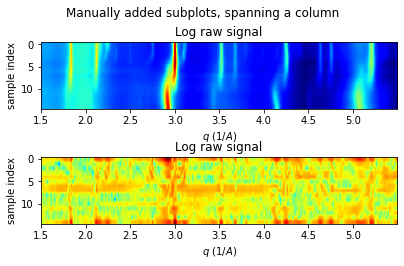

In [252]:
def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")
    
fig = plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
spec = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(spec[0, :])
heatmap(ax0, ax0, np.log(1 + patterns))
# annotate_axes(ax0, 'ax0')

ax1 = fig.add_subplot(spec[1, :])
heatmap(ax1, ax1, np.log10(np.abs(fast_T / patterns) ))
#annotate_axes(ax10, 'ax10')


# ax11 = fig.add_subplot(spec[1, 1])
# annotate_axes(ax11, 'ax11')

fig.suptitle('Manually added subplots, spanning a column')

In [ ]:
ax0.imshow

In [141]:
adict.keys()

dict_keys(['Log noise (relative)', 'Log raw signal', 'Log signal', 'innerB', 'innerA'])

NameError: name 'hist_data' is not defined

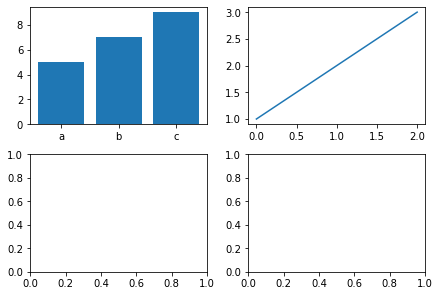

In [138]:
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(
    [
        ["bar", "plot"],
        ["hist", "image"],
    ],
)
ax_dict["bar"].bar(["a", "b", "c"], [5, 7, 9])
ax_dict["plot"].plot([1, 2, 3])
ax_dict["hist"].hist(hist_data)
ax_dict["image"].imshow([[1, 2], [2, 1]])
identify_axes(ax_dict)

In [137]:
axd[k]

<AxesSubplot:label='Log noise (relative)'>

In [130]:
axd[k]

<AxesSubplot:label='Log noise (relative)'>

In [160]:
def annotate():
    plt.xlabel('$q~(1 / A)$')
    plt.ylabel('sample index')

imargs = {'cmap': 'jet', 'aspect': aspect}

def heatmap(fig, ax, arr):
    aspect = 10

    stride = 100
    qticks = d3d.q[::stride]
    labels = ['{:0.1f}'.format(elt) for elt in qticks]
    
    ax.set_xticklabels(labels);
    ax.set_xticks(np.arange(len(qticks)) * stride);
    plt.imshow(arr, **imargs)
    plt.title('Log raw signal')
    annotate()

/Users/ollie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


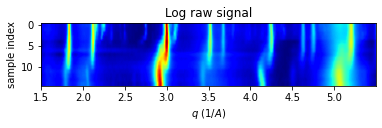

In [119]:
fig, ax = plt.subplots(1,1)
heatmap(fig, ax)

In [ ]:
plt.imshow(slow_q, cmap = 'jet')
plt.title("Interpolated background")
annotate()